In [266]:
import sys
print(sys.version)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

3.6.2 (v3.6.2:5fd33b5, Jul  8 2017, 04:57:36) [MSC v.1900 64 bit (AMD64)]


#### Q1: Write a function in python to sum up a given set of numbers other than itself

In [267]:
import numpy as np

#*** Q1 answer ***#
def sumExceptMe(inArray):
    if isinstance(inArray, list)==True and len(np.shape(inArray))==1:   # make sure input is one dimensional list(array)
        outArray = []
        inArray=np.array(inArray)
        for idx, val in enumerate(inArray):
            outArray.append(sum(inArray[np.arange(len(inArray))!=idx]))
        return outArray
    else:
        raise ValueError("Input should be one dimensional array/list !!")

# example call
inputArray = [1,2,3,4]
print(sumExceptMe(inputArray))


[9, 8, 7, 6]


#### Q2.a Download Kaggle dataset

In [268]:
# define download function
import requests

#*** Q2.a answer ***#
def downloadFromWeb(site_url, file_url, user_pass, local_filename):
    # Retrive data with login
    s = requests.Session()
    s.post(site_url, data=user_pass, verify=False ) # with 'verify=False' ignoring SSL certificate verification for simplicity
    reqData = s.get(file_url)
    
    # Write to local file as chunks of 1 MB
    localfile = open(local_filename, 'wb')
    for chunk in reqData.iter_content(chunk_size = 1024 * 1024): 
        if chunk: # filter out keep-alive new chunks
            localfile.write(chunk)
    localfile.close()
    
# downlaod target file

# data source 
site_url = 'https://www.kaggle.com/account/login?ReturnUrl=c'
file_url = 'https://www.kaggle.com/crawford/weekly-sales-transactions/downloads/Sales_Transactions_Dataset_Weekly.csv'
user_pass = {'UserName': "<kaggle_user>", 'Password': "<kaggle_pass>"}
    
# local path
local_filename = "Sales_Transactions_Dataset_Weekly.csv"

downloadFromWeb(site_url, file_url, user_pass, local_filename)


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


#### Q2.b Identify the best performing product (based on volume) 

In [269]:
import pandas as pd

# load csv
df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')

# find total sales for all weeks 
df['Product_Total'] = df.iloc[:, 1:53].sum(axis=1)

# find the index with max 'Product_Total' and then use the index to locate corresponding 'Product_Code'

#*** Q2.b answer ***#
df.iloc[[df['Product_Total'].idxmax()]] ['Product_Code'].values.tolist()[0]


'P409'

#### Q2.c Identify the most promising product (emerging product) 
- we are using slope of linear regression as the mesure of trend. The more the slope the more promising the product is.

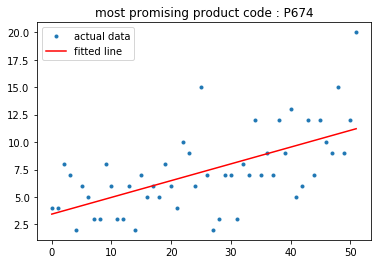

In [270]:
from scipy import stats

# just sequence number corresponding to week number starting from 0 as x
x = np.arange(0, 52, 1)

# individual row as vector/array as y
df['slope'] = df.apply(lambda row : stats.linregress(x, row[1:53].values.tolist())[0], axis=1)

# product with highest slope ( most promising product )
promising_product = df.iloc[[df['slope'].idxmax()]] ['Product_Code'].values[0]

# now plot the most promising product
y = df.loc[df['Product_Code'] == promising_product].iloc[:, 1:53].values.tolist()[0]
slope, intercept = stats.linregress(x, y)[0:2]

#*** Q2.c answer ***#
import matplotlib.pyplot as plt  
plt.title('most promising product code : ' + promising_product)
plt.plot(x, y, '.', label='actual data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend(loc=2)
plt.show()


#### Q2.d Identify the worst performing product on a biweekly basis 

In [271]:
# re-shape the dataframe for SQL like analysis (ex: group by followed by max/min )
# take only relevant columns
df_stack=df.iloc[:, 0:53]
# use 'Product_Code' as row index to make value while use stack
df_stack.index=df['Product_Code']
del df_stack['Product_Code']

# stack the dataframe to make weeks as value per product code with corresponding sales volume
df_stack = df_stack.stack().reset_index()
df_stack.columns = ['Product_Code', 'Week', 'Sales']

# create a new column with only week number, for ease of calculation
import re
df_stack['Week_No'] = df_stack.apply( lambda row:  int(re.findall('\d+', row['Week'])[0]), axis=1 )

# calculate biweekly sales per product. Here we are using numeric week_no filed for biweek calculation 
df_stack_grouped=df_stack.groupby([ 'Product_Code', ((np.floor(df_stack['Week_No']/2)+1)*2-1).astype(int) ]).agg({'Sales': 'sum'}).reset_index()
df_stack_grouped.columns = ['Product_Code', 'End_of_Week', 'Sales']

# find biweekly minimum sales
df_biweek_min_sale = df_stack_grouped.groupby('End_of_Week', as_index=False).agg({'Sales': 'min'})

# find product with biweekly minimum sales
df_worst_products_biweek = pd.merge(df_stack_grouped, df_biweek_min_sale, on =['Sales','End_of_Week'])\
                            .groupby('End_of_Week').apply(lambda x: ','.join(x.Product_Code)).reset_index()

df_worst_products_biweek.columns = [ 'End_of_Week', 'Product_Code']

#*** Q2.d answer ***#
df_worst_products_biweek

# Note 1: Every bi-week, there is several product with zero(0) sales on both weeks. So, multiple wrost products for each bi-week.

,End_of_Week,Product_Code
0,1,"P212,P213,P214,P215,P216,P217,P218,P219,P220,P..."
1,3,"P212,P213,P214,P215,P216,P217,P218,P220,P221,P..."
2,5,"P215,P216,P217,P218,P219,P220,P221,P222,P223,P..."
3,7,"P213,P214,P215,P216,P217,P219,P220,P221,P222,P..."
4,9,"P212,P213,P215,P216,P217,P218,P219,P220,P221,P..."
5,11,"P212,P214,P215,P216,P217,P218,P220,P221,P225,P..."
6,13,"P212,P213,P214,P215,P216,P217,P218,P220,P221,P..."
7,15,"P212,P213,P214,P215,P216,P217,P218,P220,P221,P..."
8,17,"P212,P214,P215,P216,P217,P218,P219,P220,P221,P..."
9,19,"P212,P213,P215,P217,P218,P219,P220,P222,P225,P..."


#### Q2.e Identify outliers from the data and output the corresponding week numbers 

In [272]:
# define a function to calculate standard outliers for each individual columns/vectors 
def findOutliers (data):
    pctl25 = data.quantile(0.25)
    pctl85 = data.quantile(0.85) 
    iqr = pctl85 - pctl25

    outlier_low = pctl25 - 1.5*iqr
    outlier_up = pctl85 + 1.5*iqr

    return data[ (data < outlier_low ) | (data > outlier_up) ]


# apply the function across all the week sales columns [w1-w51]
df_outlier = df.iloc[:, 1:53].apply(lambda col: findOutliers(col), axis=0).stack().reset_index()

# re-shape & summarise the output
del df_outlier['level_0']
df_outlier.columns = ['Week', 'Outlier']
df_outlier['Outlier'] = df_outlier['Outlier'].astype('int').astype('str')
df_outlier = df_outlier.groupby('Week').apply(lambda x: ','.join(x.Outlier)).reset_index()

#*** Q2.e answer ***#
df_outlier

# Note 1 : As there are lot's of zeros(0), there are no lower outliers. 
# Note 2 : As there are lot's of zeros(0), it will be good idea to use higher value, not the standard 75% percentile. We are using 85% insteat.



,Week,0
0,W23,72
1,W24,64
2,W25,64
3,W26,46
4,W27,47
5,W30,48
6,W36,55
7,W38,"52,52"
8,W46,55
9,W50,57


#### Q3.a Reuse code from Q2 to download the following Kaggle dataset

In [273]:
# data source 
site_url = 'https://www.kaggle.com/account/login?ReturnUrl=c'
file_url = 'https://www.kaggle.com/madhab/jobposts/downloads/data%20job%20posts.csv'
user_pass = {'UserName': "<kaggle_user>", 'Password': "<kaggle_pass>"}
    
# local path
local_filename = "data_job_posts.csv.zip"

#*** Q3.a answer ***#
#download
downloadFromWeb(site_url, file_url, user_pass, local_filename)

# load to dataframe
import zipfile
zf = zipfile.ZipFile("data_job_posts.csv.zip")
df_job = pd.read_csv(zf.open("data job posts.csv"))


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


#### Q3.b Extract the following fields from the jobpost column

In [284]:
# load required libraries
import re
from dateutil.parser import parse

# function to find string between two regex
# this function works with doc type string, instr parameter with .__doc__ while calling
def findBetween(start, end, instr):
    try: 
        return re.findall (start+'(.*?)'+end, instr, re.DOTALL)[0][1].strip() # take the 2nd part, in position 1
    except IndexError:
        return None    

# validate date format for date field (DEADLINE)
def formatDate(string):
    try:
        if string is not None:
            string.split('\n')[0].strip()
            return parse(string).strftime('%Y-%m-%d %H:%M:%S')
        else:
            return None
    except ValueError:
        return None
    
# pattern observed in the filed 'jobpost' for different section
#new line, followed by sequence of upper case character or sequence of more that 10 '-'
section_pattern = '(\n[A-Z /-]+:|\n-{10,})' 

#*** Q3.b answer ***#
# Q3.b.1. Job Title
key_words = '(JOB TITLE:|TITLE:)'
df_job_title = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_job_title.columns = ['Job_Title']
# Q3.b.1. answer
df_job_title

# Q3.b.2. Position Duration
key_words = '(POSITION DURATION:|DURATION:)'
df_position_duration = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_position_duration.columns = ['Position_Duration']
# Q3.b.2. answer
df_position_duration
     
# Q3.b.3. Position Location
key_words = '(POSITION LOCATION:|LOCATION:)'
df_position_location = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_position_location.columns = ['Position_Location']
# Q3.b.2. answer
df_position_location

# Q3.b.4. Job Description
key_words = '(JOB DESCRIPTION:|DESCRIPTION:)'
df_job_description = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_job_description.columns = ['Job_Description']
# Q3.b.4. answer
df_job_description

# Q3.b.5. Job Responsibilities
key_words = '(JOB RESPONSIBILITIES:|RESPONSIBILITIES:)'
df_job_responsibilities = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_job_responsibilities.columns = ['Job_Responsibilities']
# Q3.b.5. answer
df_job_responsibilities

# Q3.b.6. Required Qualifications
key_words = '(REQUIRED QUALIFICATIONS:|QUALIFICATIONS:)'
df_required_qualifications = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_required_qualifications.columns = ['Required_Qualifications']
# Q3.b.6. answer
df_required_qualifications

# Q3.b.7. Remuneration
key_words = '(REMUNERATION:|SALARY:)'
df_remuneration = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_remuneration.columns = ['Remuneration']
# Q3.b.7. answer
df_remuneration

# Q3.b.8. Application Deadline
# here converting date to appropriate format
key_words = '(APPLICATION DEADLINE:|DEADLINE:)'
df_application_deadline = df_job[['jobpost']].apply(lambda row: formatDate(findBetween(key_words, section_pattern, row[0])), axis=1).to_frame()
df_application_deadline.columns = ['Application_Deadline']
# Q3.b.8. answer
df_application_deadline

# Q3.b.9. About Company
key_words = '(ABOUT COMPANY:)'
df_about_company = df_job[['jobpost']].apply(lambda row: findBetween(key_words, section_pattern, row[0]), axis=1).to_frame()
df_about_company.columns = ['About_Company']
# Q3.b.9. answer
df_about_company


#### Q3.c Identify the company with the most number of job ads in the past 2 years 

In [285]:
# check available years
df_job.Year.unique()

# Note: seems like it has latest data upto 2015. So, lets consider year 2014 & 2015 as past 2 years

df_company_jobposts = df_job[ df_job['Year'] >=2014 ].groupby('Company').agg({'jobpost': 'count'}).reset_index()

#*** Q3.c answer ***#
df_company_jobposts[ df_company_jobposts['jobpost'] == df_company_jobposts.jobpost.values.max()]


,Company,jobpost
685,Mentor Graphics Development Services CJSC,83


#### Q3.d Identify the month with the largest number of job ads over the years 

In [276]:
df_year_month = df_job.groupby(['Year', 'Month']).agg({'jobpost': 'count'}).reset_index()

df_year_max_month = df_year_month.assign( max_jobpost=df_year_month.groupby('Year')['jobpost'].transform('max')).sort_values('Month')

#*** Q3.d answer ***#
df_year_max_month[ df_year_max_month['jobpost']==df_year_max_month['max_jobpost'] ].iloc[:, 0:3].sort_values('Year')

,Year,Month,jobpost
6,2004,7,96
13,2005,2,116
25,2006,2,123
41,2007,6,155
53,2008,6,186
56,2008,9,186
66,2009,7,124
74,2010,3,154
86,2011,3,160
103,2012,8,228


#### Q3.e Find median, mean, min and max values for each product 
- ##### Seems like this question is relevant to Q2. So, calculating from Q2 data

In [277]:
# load csv
df_product = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')

df_product.iloc[:, 0:53]

#*** Q3.e answer ***#
df_product.assign( MEAN=df_product.apply( lambda row : row[1:53].mean() , axis=1) ) \
          .assign( MEDIAN=df_product.apply( lambda row : row[1:53].median() , axis=1) ) \
           [['Product_Code', 'MIN', 'MAX', 'MEAN', 'MEDIAN']]

,Product_Code,MIN,MAX,MEAN,MEDIAN
0,P1,3,21,9.634615,10.0
1,P2,0,10,3.980769,3.5
2,P3,3,14,8.692308,8.0
3,P4,2,19,8.269231,8.0
4,P5,3,18,8.461538,8.0
5,P6,0,11,4.230769,4.0
6,P7,0,10,4.096154,3.5
7,P8,3,15,8.653846,9.0
8,P9,3,18,10.365385,10.0
9,P10,9,33,19.423077,19.0


#### Q3.f Clean text and generate new text from Job Responsibilities column: 
- The new text shall not contain any stop words, and the plural words shall be converted into singular words

In [278]:
# install nltk and download necessary data 
import nltk
#nltk.download()

from nltk import word_tokenize
from nltk.corpus import stopwords

stopwordslist = set(stopwords.words('english'))

# install Pattern3
# pip install Pattern3
# then edit "Python36\Lib\site-packages\pattern3\text\tree.py" by adding word "izip" at line 36 (indented with 4 space) 
from pattern3.en import singularize

## replace all except alphabets and apostrophe
def numPuntuationCleaner(inputStr):
    # replace all back tick with single quote
    inputStr = re.sub(r"`", "'", inputStr)
    # replace all except single quote & words 
    inputStr = re.sub(r"[^\w' ]", "", inputStr)
    # replace all under score "_" with space
    inputStr = re.sub(r"[_]", " ", inputStr)
    # replace all single quotes except apostrophe s,t,d & ve.
    # This should be done after replace all except single quote & words 
    inputStr = re.sub(r"(?!'[stdm]|'ve|'re)'", " ", inputStr)
    # Replace all standalone numbers and numbers that are start of word
    inputStr = re.sub("^\d+| \d+|\t+\d+", " ", inputStr)
    # Replace extra spaces and tabs with single spaces
    inputStr=re.sub(r" +|\t+", " ", inputStr)
    # Repace starting and trailing spaces and tabs
    out=re.sub(r"^ +| +$|^\t+|\t+$", "", inputStr)
    return out

# define a function to clean stop words and convert plural to singular
def removeStopwordsAndPlurals(words, stopwordslist):
    if words is not None:
        wordlist = words.split()
        retlist = []
        for w in wordlist:
            w = numPuntuationCleaner(w) # take only alphabetic
            if w.lower() not in stopwordslist: # match loer case with stop words list
                retlist.append(singularize(w)) # return singular form
        return retlist
    else:
        return '' # returning empty string instead of None. It will make it ear to use ' '.join() in .apply


df_job_responsibilities_clean = df_job_responsibilities[['Job_Responsibilities']]\
                                .apply(lambda row:' '.join(removeStopwordsAndPlurals(row[0],stopwordslist)).strip(), axis=1)\
                                .to_frame() # extra .strip() to make suer empty string become None
df_job_responsibilities_clean.columns = ['Job_Responsibilities_Clean']

#*** Q3.f answer ***#
df_job_responsibilities_clean


,Job_Responsibilities_Clean
0,Supervise financial management administrative ...
1,Presenting CC program interested party Assist...
2,Working Country Director provide environmental...
3,Identify gap knowledge overseeing information ...
4,Rendering technical assistance Database Manage...
5,
6,
7,
8,Coordinating work subordinate employee Mainta...
9,


#### Q3.g Store the results in a new Dataframe/SQL table 

In [279]:
# concat all dataframe
df_jobnew = pd.concat([ df_job_title,
            df_position_duration,
            df_position_location,
            df_job_description,
            df_job_responsibilities,
            df_job_responsibilities_clean,
            df_required_qualifications,
            df_remuneration,
            df_application_deadline,
            df_about_company ], axis=1
         )

#*** Q3.g Answers ***#
df_jobnew

,Job_Title,Position_Duration,Position_Location,Job_Description,Job_Responsibilities,Job_Responsibilities_Clean,Required_Qualifications,Remuneration,Application_Deadline,About_Company
0,Chief Financial Officer,None,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,Supervise financial management administrative ...,"To perform this job successfully, an\r\nindivi...",None,2004-01-26 00:00:00,None
1,Full-time Community Connections Intern (paid i...,3 months,"IREX Armenia Main Office; Yerevan, Armenia",IREX currently seeks to fill the position of a...,- Presenting the CC program to interested part...,Presenting CC program interested party Assist...,- Bachelor's Degree; Master's is preferred;\r\...,Commensurate with experience.,2004-01-12 00:00:00,The International Research & Exchanges Board (...
2,Country Coordinator,Renewable annual contract,"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,Working Country Director provide environmental...,"- Degree in environmentally related field, or ...",Salary commensurate with experience.,2004-01-20 00:00:00,The Caucasus Environmental NGO Network is a\r\...
3,BCC Specialist,None,"Manila, Philippines",The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,Identify gap knowledge overseeing information ...,"- Advanced degree in public health, social sci...",None,2004-01-23 00:00:00,None
4,Software Developer,None,"Yerevan, Armenia",None,- Rendering technical assistance to Database M...,Rendering technical assistance Database Manage...,- University degree; economical background is ...,Will be commensurate with the norms accepted i...,2004-01-20 18:00:00,None
5,Saleswoman,None,"Yerevan, Armenia",Saleswoman will sell menswear and accessories.,None,,"- Candidates should be female, 20-30 years old...","Starting salary - 40,000 AMD.",2004-02-01 00:00:00,None
6,Chief Accountant/ Finance Assistant,None,"Yerevan, Armenia",The Armenian Branch Office of the Open Society...,None,,- University degree in finance/ accounting; \r...,None,2004-01-16 18:00:00,None
7,Non-paid part or full time Programmatic Intern,6 months,IREX Armenia Main Office,IREX currently seeks to fill the position of n...,None,,None,None,2004-01-16 00:00:00,The International Research & Exchanges Board (...
8,Assistant to Managing Director,None,"Yerevan, Armenia",None,- Coordinating the work of subordinate employe...,Coordinating work subordinate employee Mainta...,- University degree;\r\n- At least 3 years of ...,Will be commensurate with the norms accepted i...,2004-01-27 18:00:00,None
9,"Program Assistant (INL), FSN-8; FP-6*",None,None,None,None,,NOTE: All applicants are instructed to\r\naddr...,*Not-Ordinarily Resident: Grade: FP-06 to be c...,None,None


#### Q4.a Download test.csv from https://www.kaggle.com/rishisankineni/text-similarity/data 

In [280]:
# data source 
site_url = 'https://www.kaggle.com/account/login?ReturnUrl=c'
file_url = 'https://www.kaggle.com/rishisankineni/text-similarity/downloads/test.csv'
user_pass = {'UserName': "obaidul", 'Password': "ObuObaid1982"}
    
# local path
local_filename = "test.csv"

#*** Q4.a answer ***#
user_pass = {'UserName': "<kaggle_user>", 'Password': "<kaggle_pass>"}


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


#### Q4.b Load the data to a Spark/Pandas data frame 

In [281]:
df_similarity = pd.read_csv('test.csv')

#*** Q4.b answer ***#
df_similarity

,test_id,description_x,description_y,same_security
0,0,semtech corp,semtech corporation,NaN
1,1,vanguard mid cap index,vanguard midcap index - a,NaN
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN
3,3,vanguard total bond index adm,vanguard total bond market index,NaN
4,4,oakmark international fund class i,oakmark international cl i,NaN
5,5,pfizer inc div: 1.200,pfizer inc com,NaN
6,6,spartan global ex us index fid adv cl,sptn glb xus idx adv,NaN
7,7,vanguard total bond market idx-adm,vanguard total bond market index fund investor...,NaN
8,8,banco latinoamericano de exportacio class e co...,banco latinoamericano come-e,NaN
9,9,baidu inc fadr 1 adr reps 0.1 ord shs,baidu inc spons ads repr 0.10 ord cls a us0.00005,NaN


#### Q4.c Calculate similarity between description_x and description_y and store resultant scores in a new column 

In [287]:
# we will use fuzzywuzzy package for string similarity
# we will calculate using 3 types of matching algorithm and use simple median  of these 3 as final score
from fuzzywuzzy import fuzz

#Simple Ratio
df_similarity_simple = df_similarity.apply(lambda row: fuzz.ratio(row['description_x'], row['description_y']), axis=1).to_frame()
df_similarity_simple.columns = ['simple_score']

#Partial Ratio
df_similarity_partial = df_similarity.apply(lambda row: fuzz.partial_ratio(row['description_x'], row['description_y']), axis=1).to_frame()
df_similarity_partial.columns = ['partial_score']

#Token Sort Ratio
df_similarity_sort = df_similarity.apply(lambda row: fuzz.token_sort_ratio(row['description_x'], row['description_y']), axis=1).to_frame()
df_similarity_sort.columns = ['sort_score']

# 
df_similarity_3scores = df_similarity.join(df_similarity_simple).join(df_similarity_partial).join(df_similarity_sort)

df_similarity_final_scores = df_similarity_3scores.assign(similarity_score_final = \
                             df_similarity_3scores[['simple_score','partial_score','sort_score']].\
                             apply( lambda row: row.median(),axis=1)
                            )

#*** Q4.c answer ***#
df_similarity_final_scores # column 'similarity_score_final'

,test_id,description_x,description_y,same_security,simple_score,partial_score,sort_score,similarity_score_final
0,0,semtech corp,semtech corporation,NaN,77,100,77,77.0
1,1,vanguard mid cap index,vanguard midcap index - a,NaN,89,95,89,89.0
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN,92,81,92,92.0
3,3,vanguard total bond index adm,vanguard total bond market index,NaN,82,76,82,82.0
4,4,oakmark international fund class i,oakmark international cl i,NaN,87,85,87,87.0
5,5,pfizer inc div: 1.200,pfizer inc com,NaN,63,79,65,65.0
6,6,spartan global ex us index fid adv cl,sptn glb xus idx adv,NaN,70,65,60,65.0
7,7,vanguard total bond market idx-adm,vanguard total bond market index fund investor...,NaN,71,88,69,71.0
8,8,banco latinoamericano de exportacio class e co...,banco latinoamericano come-e,NaN,60,86,67,67.0
9,9,baidu inc fadr 1 adr reps 0.1 ord shs,baidu inc spons ads repr 0.10 ord cls a us0.00005,NaN,65,73,67,67.0


#### Q4.d Parallelise the matching process (bonus) 
- ##### we will be using 2 solutions for this 1) using python library'dask' 2) using pyspark
- ##### 1) using python library'dask'

In [288]:
import dask.dataframe as dd

# Convert existing pandas dataframe. It will maintain index of pandas dataframe
ddf_similarity = dd.from_pandas(df_similarity, npartitions=3) # 3 partitions, to process 3 in parallel

# check sample data from each of 3 partition
ddf_similarity.get_partition(0).head(10) #172 
ddf_similarity.get_partition(1).head(10) #172
ddf_similarity.get_partition(2).head(10) #172

# calculate similarities
from fuzzywuzzy import fuzz
#Simple Ratio
ddf_similarity_simple = ddf_similarity.apply(lambda row: fuzz.ratio(row[1], row[2]), axis=1 )
#Partial Ratio
ddf_similarity_partial = ddf_similarity.apply(lambda row: fuzz.partial_ratio(row[1], row[2]), axis=1 )
#Partial Ratio
ddf_similarity_sort = ddf_similarity.apply(lambda row: fuzz.token_sort_ratio(row[1], row[2]), axis=1 )

# merge 3 scores
ddf_similarity_3scores = ddf_similarity.join(ddf_similarity_simple.to_frame('simple_score'))\
                                       .join(ddf_similarity_partial.to_frame('partial_score'))\
                                       .join(ddf_similarity_sort.to_frame('sort_score'))
                                      
# median score
ddf_similarity_median = ddf_similarity_3scores.apply(lambda row: float(np.median([row[4], row[5], row[6]])), axis=1 )

# final dataframe
df_similarity_final_scores=ddf_similarity_3scores.join(ddf_similarity_median.to_frame('similarity_score_final'))

#*** Q4.d answer (with dask) ***#
# column 'similarity_score_final'
df_similarity_final_scores.get_partition(0).head(172)
df_similarity_final_scores.get_partition(1).head(172)
df_similarity_final_scores.get_partition(2).head(172)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\dask\dataframe\core.py:2665: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


,test_id,description_x,description_y,same_security,simple_score,partial_score,sort_score,similarity_score_final
344,344,af bond fd amer r6,the bond fund of america-a,NaN,59,72,68,68.0
345,345,allergan plc,allergan plc f,NaN,92,100,92,92.0
346,346,vale sa,vale s a adr,NaN,74,86,63,74.0
347,347,vanguard short-term corporate bond etf,vanguard short-term corporate bond,NaN,94,100,94,94.0
348,348,vanguard index fds vanguard small cap growth v...,vanguard small-cap grwth etf,NaN,59,86,59,59.0
349,349,vanguard short-term bondetf,vanguard short term etf,NaN,88,83,92,88.0
350,350,goldman sachs mgd futures strat a,aqr mgd futures strat fd cl i,NaN,65,73,65,65.0
351,351,vanguard total bond index adm,vanguard total bond market index fund investor...,NaN,66,76,61,66.0
352,352,xinyuan real estate com,xinyuan real estate co ltd spon adr,NaN,76,96,76,76.0
353,353,ishares core u.s. aggregate bond etf,ishares core total us bond market etf,NaN,66,64,67,66.0


#### Q4.d Parallelise the matching process (bonus) 
- ##### we will be using 2 solutions for this 1) using python library'dask' 2) using 'pyspark'
- ##### 2) solution using 'pyspark'
- ##### Note: this is pyspark code. Corresponding zepplin notebook also provided seek_Q4.d.json

In [ ]:
################ pyspark ##################

import requests

# download function
def downloadFromWeb(site_url, file_url, user_pass, local_filename):
    # Retrive data with login
    s = requests.Session()
    s.post(site_url, data=user_pass, verify=False ) # with 'verify=False' ignoring SSL certificate verification for simplicity
    reqData = s.get(file_url)
    
    # Write to local file as chunks of 1 MB
    localfile = open(local_filename, 'wb')
    for chunk in reqData.iter_content(chunk_size = 1024 * 1024): 
        if chunk: # filter out keep-alive new chunks
            localfile.write(chunk)
    localfile.close()

# data source 
site_url = 'https://www.kaggle.com/account/login?ReturnUrl=c'
file_url = 'https://www.kaggle.com/rishisankineni/text-similarity/downloads/test.csv'
user_pass = {'UserName': "<kaggle_user>", 'Password': "<kaggle_pass>"}

# local path
local_filename = "/tmp/test.csv"

# doanload
downloadFromWeb(site_url, file_url, user_pass, local_filename)


# load csv to dataframe
from pyspark.sql import SparkSession

sqlCtx =SparkSession.builder.appName("Spark SQL").config("spark.some.config.option", "some-value").getOrCreate()

df_similarity = (
   sqlCtx.read
   .format("com.databricks.spark.csv")
   .options(header='true', inferschema='true')   
   .load("file:///tmp/test.csv")
)


# calculate 3 types to similarities using fuzzywuzzy package
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import udf
from fuzzywuzzy import fuzz

# Simple Ratio
fn_simple_score = udf( lambda str1, str2 : fuzz.ratio(str1, str2), IntegerType())
df_similarity_simple=df_similarity.withColumn( 'simple_score',   fn_simple_score( df_similarity.description_x, df_similarity.description_y) ).select('test_id','simple_score')

# Partial Ratio
fn_partial_score = udf( lambda str1, str2 : fuzz.partial_ratio(str1, str2), IntegerType())
df_similarity_partial=df_similarity.withColumn( 'partial_score',   fn_partial_score( df_similarity.description_x, df_similarity.description_y) ).select('test_id','partial_score')

# Sort Ratio
fn_sort_score = udf( lambda str1, str2 : fuzz.token_sort_ratio(str1, str2), IntegerType())
df_similarity_sort=df_similarity.withColumn( 'sort_score',   fn_sort_score( df_similarity.description_x, df_similarity.description_y) ).select('test_id','sort_score')

 
# register all as table to use sql queries
df_similarity.registerTempTable("df_similarity")
df_similarity_simple.registerTempTable("df_similarity_simple")
df_similarity_partial.registerTempTable("df_similarity_partial")
df_similarity_sort.registerTempTable("df_similarity_sort")

# sql query to concate all dataframes/tables
sqltext= '''
select A.*, B.simple_score, C.partial_score, D.sort_score 
  from df_similarity A, df_similarity_simple B, df_similarity_partial C, df_similarity_sort D
 where A.test_id=B.test_id 
   and A.test_id=B.test_id
   and A.test_id=C.test_id
   and A.test_id=D.test_id
 '''

from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, expr
import numpy as np

# UDF to calculate median
fn_median = udf( lambda int1, int2, int3 : float(np.median([int1, int2, int3])) , FloatType() ) # need to cast here to convert numpy datatype

# concate all dataframes and calculate final score
df_similarity_final_scores=spark.sql(sqltext).\
                           withColumn( 'similarity_score_final',\
                                       fn_median( col('simple_score'), col('partial_score'), col('sort_score') ) 
                           )

#*** Q4.d answer (with pyspark) ***#
df_similarity_final_scores.show(516) # column 'similarity_score_final'
